In [5]:
import torch 
torch.manual_seed(1)
import sys
sys.path.append('..')

from targets.density_estimation_target import *
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'

In [42]:
import torch
from torch import nn
from tqdm import tqdm


class MultivariateNormalReference(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p

    def sample(self, num_samples):
        return torch.randn([num_samples, self.p])

    def log_density(self, z):
        return -torch.sum(torch.square(z)/2, dim = -1) - torch.log(torch.tensor([2*torch.pi], device = z.device))*self.p/2

class RealNVPDensityEstimatorLayer(nn.Module):
    def __init__(self,p,hidden_dim, q_log_density):
        super().__init__()
        self.p = p
        net = []
        hs = [self.p] + hidden_dim + [2*self.p]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.Tanh(),
            ])
        net.pop()
        self.net = nn.Sequential(*net)

        self.mask = [torch.cat([torch.zeros(int(self.p/2)), torch.ones(self.p - int(self.p/2))], dim = 0),torch.cat([torch.ones(int(self.p/2)), torch.zeros(self.p - int(self.p/2))], dim = 0)]
        self.q_log_density = q_log_density
        self.lr = 5e-4

    def sample_forward(self,x):
        with torch.no_grad():
            z = x
            for mask in reversed(self.mask):
                out = self.net(mask * z)
                m, log_s = out[...,:self.p]*(1 - mask),out[...,self.p:]*(1 - mask)
                z = (z*(1 - mask) * torch.exp(log_s)+m) + (mask * z)
            return z

    def sample_backward(self, z):
        with torch.no_grad():
            x = z
            for mask in self.mask:
                out = self.net(x*mask)
                m, log_s = out[...,:self.p]* (1 - mask),out[...,self.p:]* (1 - mask)
                x = ((x*(1-mask) -m)/torch.exp(log_s)) + (x*mask)
            return x

    def log_psi(self, x):
        z = x
        log_det = torch.zeros(x.shape[:-1]).to(x.device)
        for mask in reversed(self.mask):
            mask = mask.to(x.device)
            out = self.net(mask * z)
            m, log_s = out[...,:self.p]* (1 - mask),out[...,self.p:]* (1 - mask)
            z = (z*(1 - mask)*torch.exp(log_s) + m) + (mask*z)
            log_det += torch.sum(log_s, dim = -1)
        return self.q_log_density(z) + log_det

class MixedModelDensityEstimator(nn.Module):
    def __init__(self, target_samples,structure):
        super().__init__()
        self.target_samples = target_samples
        self.p = self.target_samples.shape[-1]
        self.structure = structure
        self.N = len(self.structure)

        self.reference = MultivariateNormalReference(self.p)

        self.model = [structure[-1][0](self.p,self.structure[-1][1], q_log_density=self.reference.log_density)]
        for i in range(self.N - 2, -1, -1):
            self.model.insert(0, structure[i][0](self.p, structure[i][1], q_log_density=self.model[0].log_psi))
        self.loss_values= []

    def sample_model(self, num_samples):
        with torch.no_grad():
            z = self.reference.sample(num_samples)
            for i in range(self.N - 1, -1, -1):
                z = self.model[i].sample_backward(z)
            return z

    def sample_latent(self, x):
        with torch.no_grad():
            for i in range(self.N):
                x = self.model[i].sample_forward(x)
            return x

    def log_density(self, x):
        return self.model[0].log_psi(x)

    def loss(self, batch):
        return - self.log_density(batch).mean()

    def train(self, epochs, batch_size = None):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)
        self.para_dict = []
        for model in self.model:
            self.para_dict.insert(-1,{'params':model.parameters(), 'lr': model.lr})
            model.to(device)
        self.optimizer = torch.optim.Adam(self.para_dict)

        if batch_size is None:
            batch_size = self.target_samples.shape[0]
        dataset = torch.utils.data.TensorDataset(self.target_samples)

        pbar = tqdm(range(epochs))
        for t in pbar:
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            for i, batch in enumerate(dataloader):
                x = batch[0].to(device)
                self.optimizer.zero_grad()
                batch_loss = self.loss(x)
                batch_loss.backward()
                self.optimizer.step()
            with torch.no_grad():
                iteration_loss = torch.tensor([self.loss(batch[0].to(device)) for i, batch in enumerate(dataloader)]).mean().item()
            self.loss_values.append(iteration_loss)
            pbar.set_postfix_str('loss = ' + str(round(iteration_loss,6)))
        self.to('cpu')
        for model in self.model:
            model.to(torch.device('cpu'))

class NFNDRE(nn.Module):
    def __init__(self, target_samples, hidden_dims):
        super().__init__()

        self.target_samples = target_samples
        self.p = target_samples.shape[-1]

        network_dimensions = [self.p] + hidden_dims + [1]
        network = []
        for h0, h1 in zip(network_dimensions, network_dimensions[1:]):
            network.extend([nn.Linear(h0, h1), nn.SiLU(), ])
        network.pop()
        self.logit_r = nn.Sequential(*network)

        if self.p >= 2:
            cov = torch.cov(self.target_samples.T)
        else:
            cov = torch.var(self.target_samples, dim=0) * torch.eye(self.p)
        self.reference = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.mean(self.target_samples, dim=0), cov)

        self.loss_values=[]
        self.log_constant = None
        
        self.reference_samples = self.reference.sample([self.target_samples.shape[0]])
        self.NF = MixedModelDensityEstimator(torch.cat([self.target_samples, self.reference_samples], dim = 0), [[RealNVPDensityEstimatorLayer,[64,64]],[RealNVPDensityEstimatorLayer,[64,64]]])

    def train_NF(self, epochs, batch_size):
        self.NF.train(epochs, batch_size)
    
    def log_density(self, x):
        return self.log_density_ratio(x) + self.reference.log_prob(x)

    def log_density_ratio(self,x):
        z = self.NF.sample_latent(x)
        return self.logit_r(z).squeeze(-1)

    def estimate_constant(self):
        cat = torch.cat([self.target_samples, self.reference.sample([self.target_samples.shape[0]])], dim =0)
        self.log_constant = torch.max(self.log_density_ratio(cat))

    def sample(self, num_samples):
        if self.log_constant is None:
            print('estimating rejection sampling constant')
            self.estimate_constant()
        fake = self.reference.sample([num_samples])
        log_density_ratios = self.log_density_ratio(fake)
        accepted = torch.log(torch.rand(num_samples)) < log_density_ratios - self.log_constant
        return fake[accepted]

    def loss(self, X):
        Z = self.NF.sample_latent(X)
        fake_Z = self.NF.sample_latent(self.reference.sample(X.shape[:-1]))
        log_sigmoid = torch.nn.LogSigmoid()
        return -torch.mean(log_sigmoid(self.logit_r(Z))+log_sigmoid(-self.logit_r(fake_Z)))

    def train(self, epochs, batch_size = None):
        self.para_list = list(self.parameters())

        self.optimizer = torch.optim.Adam(self.para_list, lr=5e-3)
        if batch_size is None:
            batch_size = self.target_samples.shape[0]
        dataset = torch.utils.data.TensorDataset(self.target_samples)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)

        pbar = tqdm(range(epochs))
        for t in pbar:
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            for i, batch in enumerate(dataloader):
                x = batch[0].to(device)
                self.optimizer.zero_grad()
                batch_loss = self.loss(x)
                batch_loss.backward()
                self.optimizer.step()
            with torch.no_grad():
                iteration_loss = torch.tensor([self.loss(batch[0].to(device)) for i, batch in enumerate(dataloader)]).mean().item()
            self.loss_values.append(iteration_loss)
            pbar.set_postfix_str('loss = ' + str(round(iteration_loss,6)))
        self.to(torch.device('cpu'))

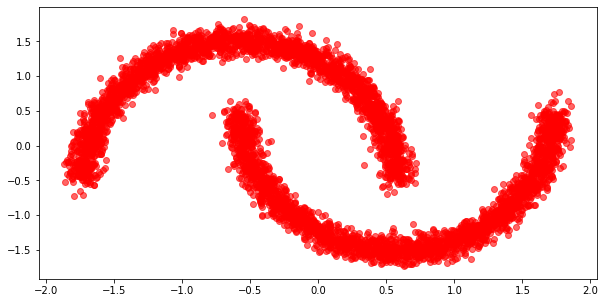

In [43]:
num_samples = 5000
target =Moons()
target.target_visual()
target_samples = target.sample(num_samples)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:39<00:00,  5.02it/s, loss = 2.524249]


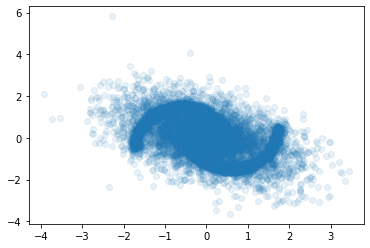

In [58]:
nfndre = NFNDRE(target_samples, [64,64,64])
nfndre.train_NF(500, 5000)
plt.scatter(nfndre.NF.target_samples[:,0].numpy(), nfndre.NF.target_samples[:,1].numpy(), alpha = .1)

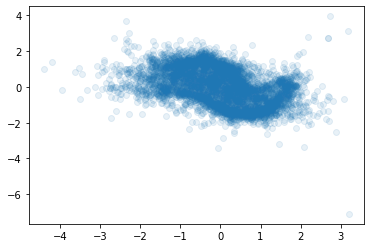

In [62]:
samples = nfndre.NF.sample_model(5000)
plt.scatter(samples[:,0].numpy(),samples[:,1].numpy(), alpha = .1)

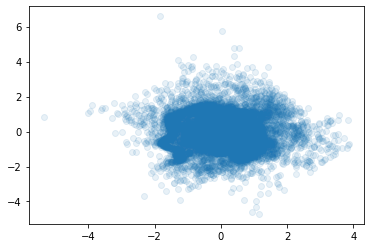

In [63]:
proxy_samples = nfndre.NF.sample_latent(nfndre.NF.target_samples)
plt.scatter(proxy_samples[:,0].numpy(),proxy_samples[:,1].numpy(), alpha = .1)

In [61]:
nfndre.train(500,5000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:25<00:00,  5.82it/s, loss = 0.71574]


estimating rejection sampling constant
tensor(0.0261, grad_fn=<MulBackward0>)


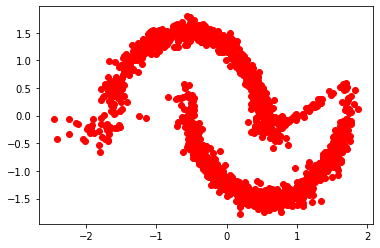

In [64]:
samples = nfndre.sample(50000)
plt.scatter(samples[:,0].numpy(), samples[:,1].numpy(), color = 'red')
print(1/torch.exp(nfndre.log_constant))